In [1]:
from visual_behavior_glm.src.glm import GLM
import visual_behavior_glm.src.GLM_fit_tools as gft
import visual_behavior_glm.src.GLM_analysis_tools as gat
import visual_behavior_glm.src.GLM_visualization_tools as gvt

import visual_behavior.utilities as vbu
import visual_behavior.plotting as vbp
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.utils as vis_utils
import visual_behavior.database as db

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import scikit_posthocs

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib inline
%widescreen

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")


# Collect cached results from mongodb

In [3]:
glm_version = '6_L2_optimize_by_session'
conn = db.Database('visual_behavior_data')
database = 'ophys_glm'
results_full = pd.DataFrame(list(conn[database]['results_full'].find({'glm_version':glm_version})))
results_summary = pd.DataFrame(list(conn[database]['results_summary'].find({'glm_version':glm_version})))

In [4]:
len(results_full)

49148

# get the experiments table

In [5]:
experiments_table = loading.get_filtered_ophys_experiment_table()
len(experiments_table)

1418

# basic exploration

In [6]:
experiments_table['targeted_structure'].value_counts()

VISp     794
VISl     447
VISam     91
VISal     86
Name: targeted_structure, dtype: int64

In [7]:
experiments_table['cre_line'].value_counts()

Slc17a7-IRES2-Cre    682
Vip-IRES-Cre         479
Sst-IRES-Cre         257
Name: cre_line, dtype: int64

In [8]:
results_full.head()

,_id,cell_specimen_id,Full__avg_cv_var_train,Full__avg_cv_var_test,Full__avg_cv_var_test_full_comparison,Full__avg_cv_adjvar_train,Full__avg_cv_adjvar_test,Full__avg_cv_adjvar_test_full_comparison,Full__absolute_change_from_full,Full__adj_dropout,...,single-model_timing1D__adj_dropout,single-beh_model__avg_cv_var_train,single-beh_model__avg_cv_var_test,single-beh_model__avg_cv_var_test_full_comparison,single-beh_model__avg_cv_adjvar_train,single-beh_model__avg_cv_adjvar_test,single-beh_model__avg_cv_adjvar_test_full_comparison,single-beh_model__absolute_change_from_full,single-beh_model__dropout,single-beh_model__adj_dropout
0,5f4f3569dd32c82ff30675f5,1028820226,0.176416,0.152772,0.152772,0.176416,0.152772,0.152772,0.0,-0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f4f3569dd32c82ff30675f6,1028820231,0.255316,0.163691,0.163691,0.255316,0.163691,0.163691,0.0,-0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f4f3569dd32c82ff30675f7,1028820263,0.077342,0.040110,0.040110,0.077342,0.040110,0.040110,0.0,-0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5f4f3569dd32c82ff30675f8,1028820278,0.032269,0.006192,0.006192,0.032269,0.006192,0.006192,0.0,-0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f4f3569dd32c82ff30675f9,1028820296,0.342049,0.311865,0.311865,0.342049,0.311865,0.311865,0.0,-0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## apply a threshold on variance explained (assign to a boolean column called `above_CV_threshold`)

In [9]:
results_full['above_CV_threshold'] = results_full['Full__avg_cv_var_test'].map(lambda CV: CV>=0.01)

In [10]:
results_summary = results_summary.merge(
    results_full[['ophys_experiment_id','cell_specimen_id','above_CV_threshold']],
    left_on = ['ophys_experiment_id','cell_specimen_id'],
    right_on = ['ophys_experiment_id','cell_specimen_id'],
    how='left'
)

In [11]:
results_summary.sample(5)

,_id,dropout,absolute_change_from_full,variance_explained,variance_explained_full,fraction_change_from_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,...,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,entry_time_utc,above_CV_threshold
1855157,5f4fd8b54c894cf86c711601,misses,-0.000051,0.188906,0.188957,-0.000268,1009529599,0.000000,0.135391,0.134255,...,NaN,NaN,0,0,Vip_VISp_169,0,3,6_L2_optimize_by_session,2020-09-02 17:39:01.784728,True
1025611,5f4fd24ef1e1032d2e57f89b,image1,-0.001614,0.151787,0.153400,-0.010519,962579477,-0.319926,0.044536,0.065487,...,NaN,NaN,0,1,Slc17a7_VISp_375,0,4,6_L2_optimize_by_session,2020-09-02 17:11:42.554779,True
1583975,5f4fd7c4571429e3d56c33be,single-image6,-0.053750,0.000240,0.053990,0.000000,1016964380,0.000000,0.008673,0.000000,...,NaN,NaN,0,0,Slc17a7_VISal_163,1,4,6_L2_optimize_by_session,2020-09-02 17:35:00.261529,True
2426958,5f515c16d5452847c97edd12,post_lick_bouts,-0.000624,0.156179,0.156802,-0.003976,1017244473,-0.014747,0.217688,0.220947,...,NaN,NaN,0,1,Slc17a7_VISl_275,0,1,6_L2_optimize_by_session,2020-09-03 21:11:50.166233,True
422674,5f4fd1b22ead34eabb57d704,Full,0.000000,0.073204,0.073204,0.000000,1028803517,0.000000,0.073204,0.073204,...,NaN,z_drift_corr_um_diff,0,1,Slc17a7_VISl_275,0,1,6_L2_optimize_by_session,2020-09-02 17:09:06.698417,True


In [12]:
len(results_full['ophys_experiment_id'].unique())

1055

In [13]:
len(results_summary['ophys_experiment_id'].unique())

1055

In [14]:
results_summary.sample(5)

,_id,dropout,absolute_change_from_full,variance_explained,variance_explained_full,fraction_change_from_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,...,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,entry_time_utc,above_CV_threshold
1195820,5f4fd6abf30bf4370bc64f1a,single-running,-0.018226,0.000000,0.018226,0.000000,1018071028,0.000000,0.000000,0.018225,...,NaN,NaN,0,1,Slc17a7_VISp_263,1,1,6_L2_optimize_by_session,2020-09-02 17:30:19.460811,True
419038,5f4fd1b2606a97303d79d37a,image0,-0.000152,0.043103,0.043254,-0.003503,1028823058,-0.025399,0.031886,0.032717,...,NaN,NaN,0,0,Slc17a7_VISp_275,0,5,6_L2_optimize_by_session,2020-09-02 17:09:06.214271,True
1965560,5f4fda0e669d18969b1f1ec5,single-model_timing1D,-0.014112,0.000000,0.014112,0.000000,962560580,0.000000,0.000000,0.014127,...,NaN,NaN,0,1,Slc17a7_VISp_375,0,1,6_L2_optimize_by_session,2020-09-02 17:44:46.135813,True
465924,5f4fd1b74ad85c9090b2f5f4,single-change,-0.046981,0.001759,0.048740,0.000000,1028797486,-0.134131,0.006511,0.048539,...,NaN,NaN,0,0,Slc17a7_VISp_275,0,2,6_L2_optimize_by_session,2020-09-02 17:09:11.020450,True
426524,5f4fd1b3ec716f55189b2704,single-misses,-0.002664,0.001365,0.004029,0.000000,1028808582,0.000000,0.004586,0.005473,...,NaN,NaN,0,0,Slc17a7_VISp_187,0,2,6_L2_optimize_by_session,2020-09-02 17:09:07.141034,False


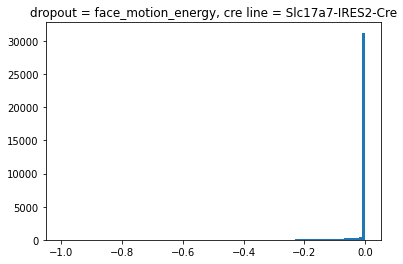

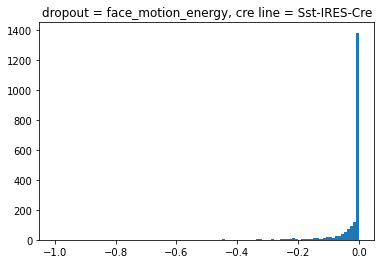

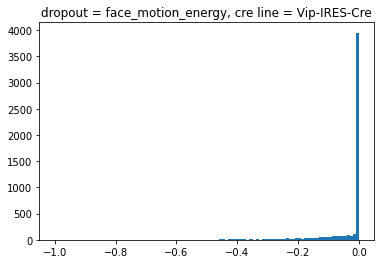

In [15]:

dropout = "face_motion_energy"
for cre_line in results_summary['cre_line'].unique():
    fig,ax=plt.subplots()
    ax.hist(results_summary.query('dropout == "{}" and cre_line == "{}"'.format(dropout, cre_line))['adj_fraction_change_from_full'],bins=np.arange(-1,0.01,0.01));
    ax.set_title('dropout = {}, cre line = {}'.format(dropout, cre_line))

## organize some things

In [16]:
np.sort(results_summary.dropout.unique())

array(['Full', 'all-images', 'beh_model', 'change', 'correct_rejects',
       'face_motion_energy', 'false_alarms', 'hits', 'image0', 'image1',
       'image2', 'image3', 'image4', 'image5', 'image6', 'image7',
       'image_expectation', 'intercept', 'misses', 'model_bias',
       'model_omissions1', 'model_task0', 'model_timing1D', 'omissions',
       'post_lick_bouts', 'post_licks', 'pre_lick_bouts', 'pre_licks',
       'pupil', 'rewards', 'running', 'single-all-images',
       'single-beh_model', 'single-change', 'single-correct_rejects',
       'single-face_motion_energy', 'single-false_alarms', 'single-hits',
       'single-image0', 'single-image1', 'single-image2', 'single-image3',
       'single-image4', 'single-image5', 'single-image6', 'single-image7',
       'single-image_expectation', 'single-misses', 'single-model_bias',
       'single-model_omissions1', 'single-model_task0',
       'single-model_timing1D', 'single-omissions',
       'single-post_lick_bouts', 'single-post_

### for clarity, exclude the individual image kernels from plots

In [36]:
kernels_to_exclude = [k for k in results_summary.dropout.unique()]
kernels_to_exclude = []

## get kernel order

In [37]:
fraction_change_order = (
    results_summary
    .query('above_CV_threshold')
    .query('dropout not in @kernels_to_exclude')
    .groupby('dropout')['adj_fraction_change_from_full']
    .mean()
    .sort_values(ascending=False)
).index
fraction_change_order
                                                                                    

Index(['Full', 'single-model_bias', 'single-model_timing1D', 'pre_licks',
       'single-model_task0', 'single-model_omissions1', 'single-time',
       'model_bias', 'model_omissions1', 'model_task0', 'model_timing1D',
       'single-beh_model', 'intercept', 'time', 'beh_model', 'pre_lick_bouts',
       'single-false_alarms', 'false_alarms', 'misses', 'change', 'hits',
       'rewards', 'post_lick_bouts', 'post_licks', 'correct_rejects',
       'image_expectation', 'face_motion_energy', 'pupil', 'running',
       'single-correct_rejects', 'single-pre_licks', 'single-pre_lick_bouts',
       'omissions', 'single-face_motion_energy', 'image5', 'image4', 'image1',
       'single-running', 'image0', 'image3', 'image2', 'image6', 'image7',
       'single-pupil', 'single-post_lick_bouts', 'single-post_licks',
       'single-rewards', 'single-misses', 'single-image_expectation',
       'single-omissions', 'single-hits', 'single-change', 'all-images',
       'visual', 'single-image6', 'single-i

## start making some plots!

In [38]:
genotype_order = ['Slc17a7-IRES2-Cre', 'Sst-IRES-Cre', 'Vip-IRES-Cre']

## just a little stats exploration

In [39]:
scikit_posthocs.posthoc_mannwhitney(
    results_summary.query('dropout == "visual" and above_CV_threshold'),
    val_col='adj_fraction_change_from_full',
    group_col='cre_line',
    p_adjust='bonferroni'
)

,Slc17a7-IRES2-Cre,Sst-IRES-Cre,Vip-IRES-Cre
Slc17a7-IRES2-Cre,-1.000000e+00,8.192766e-37,9.402803e-11
Sst-IRES-Cre,8.192766e-37,-1.000000e+00,1.599208e-50
Vip-IRES-Cre,9.402803e-11,1.599208e-50,-1.000000e+00


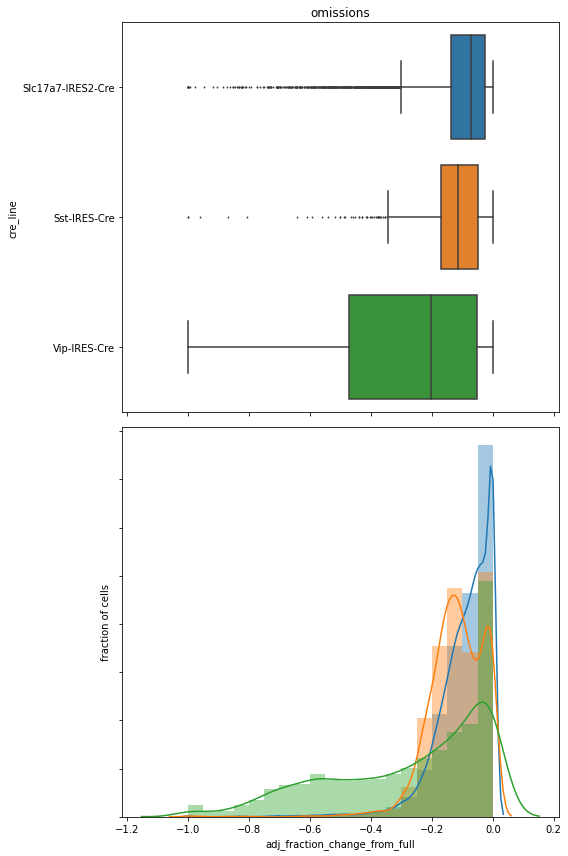

In [40]:
fig,ax=plt.subplots(2,1,figsize=(8,12), sharex=True)
dropout = 'omissions'

data_to_plot = results_summary.query("dropout == '{}' and above_CV_threshold".format(dropout))
sns.boxplot(
    data=data_to_plot,
    x='adj_fraction_change_from_full',
    y='cre_line',
    order=genotype_order,
    ax=ax[0],
    fliersize=1
)
    
for cre_line in genotype_order:
    data_to_plot = results_summary.query("dropout == '{}' and cre_line == '{}' and above_CV_threshold".format(dropout, cre_line))

    sns.distplot(
        data_to_plot['adj_fraction_change_from_full'],
        ax=ax[1],
        norm_hist=True,
        bins=np.arange(-1,0.05,0.05),
    )
ax[0].set_title(dropout)
ax[0].set_xlabel('')
ax[1].set_yticklabels([])
ax[1].set_ylabel('fraction of cells')
# ax[1].set_xlabel('fraction\nchange in\nvariance\nexplained')
fig.tight_layout()
# results_summary.query("dropout == '{}' and above_CV_threshold".format(dropout)).groupby('cre_line')['clipped_fraction_change_negative_only'].describe()


## look at the distribution of variance explained for all cells by cre line

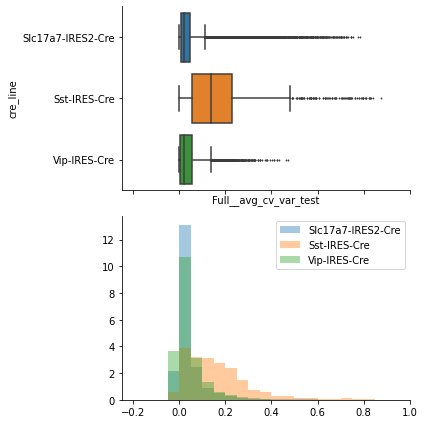

In [41]:
fig,ax=plt.subplots(2,1,figsize=(6,6),sharex=True)
for cre_line in genotype_order:
    data_to_plot = results_full.query("cre_line == '{}'".format(cre_line))
    sns.distplot(
        data_to_plot['Full__avg_cv_var_test'],
        ax=ax[1],
        norm_hist=True,
        bins=np.arange(-1,1,0.05),
        kde=False,
    )
sns.boxplot(
    data = results_full,
    x = 'Full__avg_cv_var_test',
    y = 'cre_line',
    order = genotype_order,
    fliersize=1,
    ax=ax[0]
)
ax[1].legend(genotype_order)
sns.despine()
ax[0].set_xlim(-0.25,1)
ax[1].set_xlabel('variance explained by full model')
ax[1].set_xlabel('')
fig.tight_layout()

In [42]:
results_full.groupby('cre_line')['above_CV_threshold'].value_counts()

cre_line           above_CV_threshold
Slc17a7-IRES2-Cre  True                  25277
                   False                 14020
Sst-IRES-Cre       True                   2256
                   False                   190
Vip-IRES-Cre       True                   4570
                   False                  2835
Name: above_CV_threshold, dtype: int64

In [43]:
results_full.groupby('cre_line')['above_CV_threshold'].value_counts(normalize=True)

cre_line           above_CV_threshold
Slc17a7-IRES2-Cre  True                  0.643230
                   False                 0.356770
Sst-IRES-Cre       True                  0.922322
                   False                 0.077678
Vip-IRES-Cre       True                  0.617151
                   False                 0.382849
Name: above_CV_threshold, dtype: float64

In [44]:
results_summary.sample(5)

,_id,dropout,absolute_change_from_full,variance_explained,variance_explained_full,fraction_change_from_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,...,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,entry_time_utc,above_CV_threshold,session_prefix
1820995,5f4fd8a110785e46a1ad4417,image5,-0.000214,0.035143,0.035356,-0.006039,1028826293,-0.013085,0.052511,0.053207,...,NaN,0,1,Vip_VISp_276,1,1,6_L2_optimize_by_session,2020-09-02 17:38:41.404589,True,OPHYS_1
634973,5f4fd1cc408fb9e9696031df,image6,-0.000386,0.009938,0.010324,-0.037430,1007032988,-0.176588,0.016371,0.019881,...,NaN,0,1,Slc17a7_VISp_175,1,3,6_L2_optimize_by_session,2020-09-02 17:09:32.136946,True,OPHYS_3
1549591,5f4fd7c092a8ca0207e6725c,single-image2,-0.053315,0.001111,0.054426,0.000000,1016986440,0.000000,0.018385,0.004580,...,NaN,0,0,Slc17a7_VISp_171,1,4,6_L2_optimize_by_session,2020-09-02 17:34:56.553272,True,OPHYS_4
2462394,5f515fabe6781e50cad1a83d,post_lick_bouts,-0.001716,0.079090,0.080806,-0.021240,1017240548,-0.033137,0.274633,0.284046,...,NaN,1,1,Slc17a7_VISl_169,0,3,6_L2_optimize_by_session,2020-09-03 21:27:07.247743,True,OPHYS_3
2345373,5f515770fed8b64dd1ad807a,single-all-images,0.001582,0.001582,0.000000,0.000000,853397945,0.000000,0.001639,0.000000,...,NaN,0,1,Slc17a7_VISp_175,1,3,6_L2_optimize_by_session,2020-09-03 20:52:00.917307,False,OPHYS_3


In [45]:
np.sort(results_summary.session_type.unique())

array(['OPHYS_1_images_A', 'OPHYS_1_images_B', 'OPHYS_1_images_G',
       'OPHYS_2_images_A_passive', 'OPHYS_2_images_B_passive',
       'OPHYS_2_images_G_passive', 'OPHYS_3_images_A', 'OPHYS_3_images_B',
       'OPHYS_3_images_G', 'OPHYS_4_images_A', 'OPHYS_4_images_B',
       'OPHYS_4_images_H', 'OPHYS_5_images_A_passive',
       'OPHYS_5_images_B_passive', 'OPHYS_5_images_H_passive',
       'OPHYS_6_images_A', 'OPHYS_6_images_B', 'OPHYS_6_images_H'],
      dtype=object)

In [46]:
results_summary['session_prefix'] = results_summary['session_type'].map(lambda st:st[:7])

In [47]:
np.sort(results_summary['session_prefix'].unique())

array(['OPHYS_1', 'OPHYS_2', 'OPHYS_3', 'OPHYS_4', 'OPHYS_5', 'OPHYS_6'],
      dtype=object)

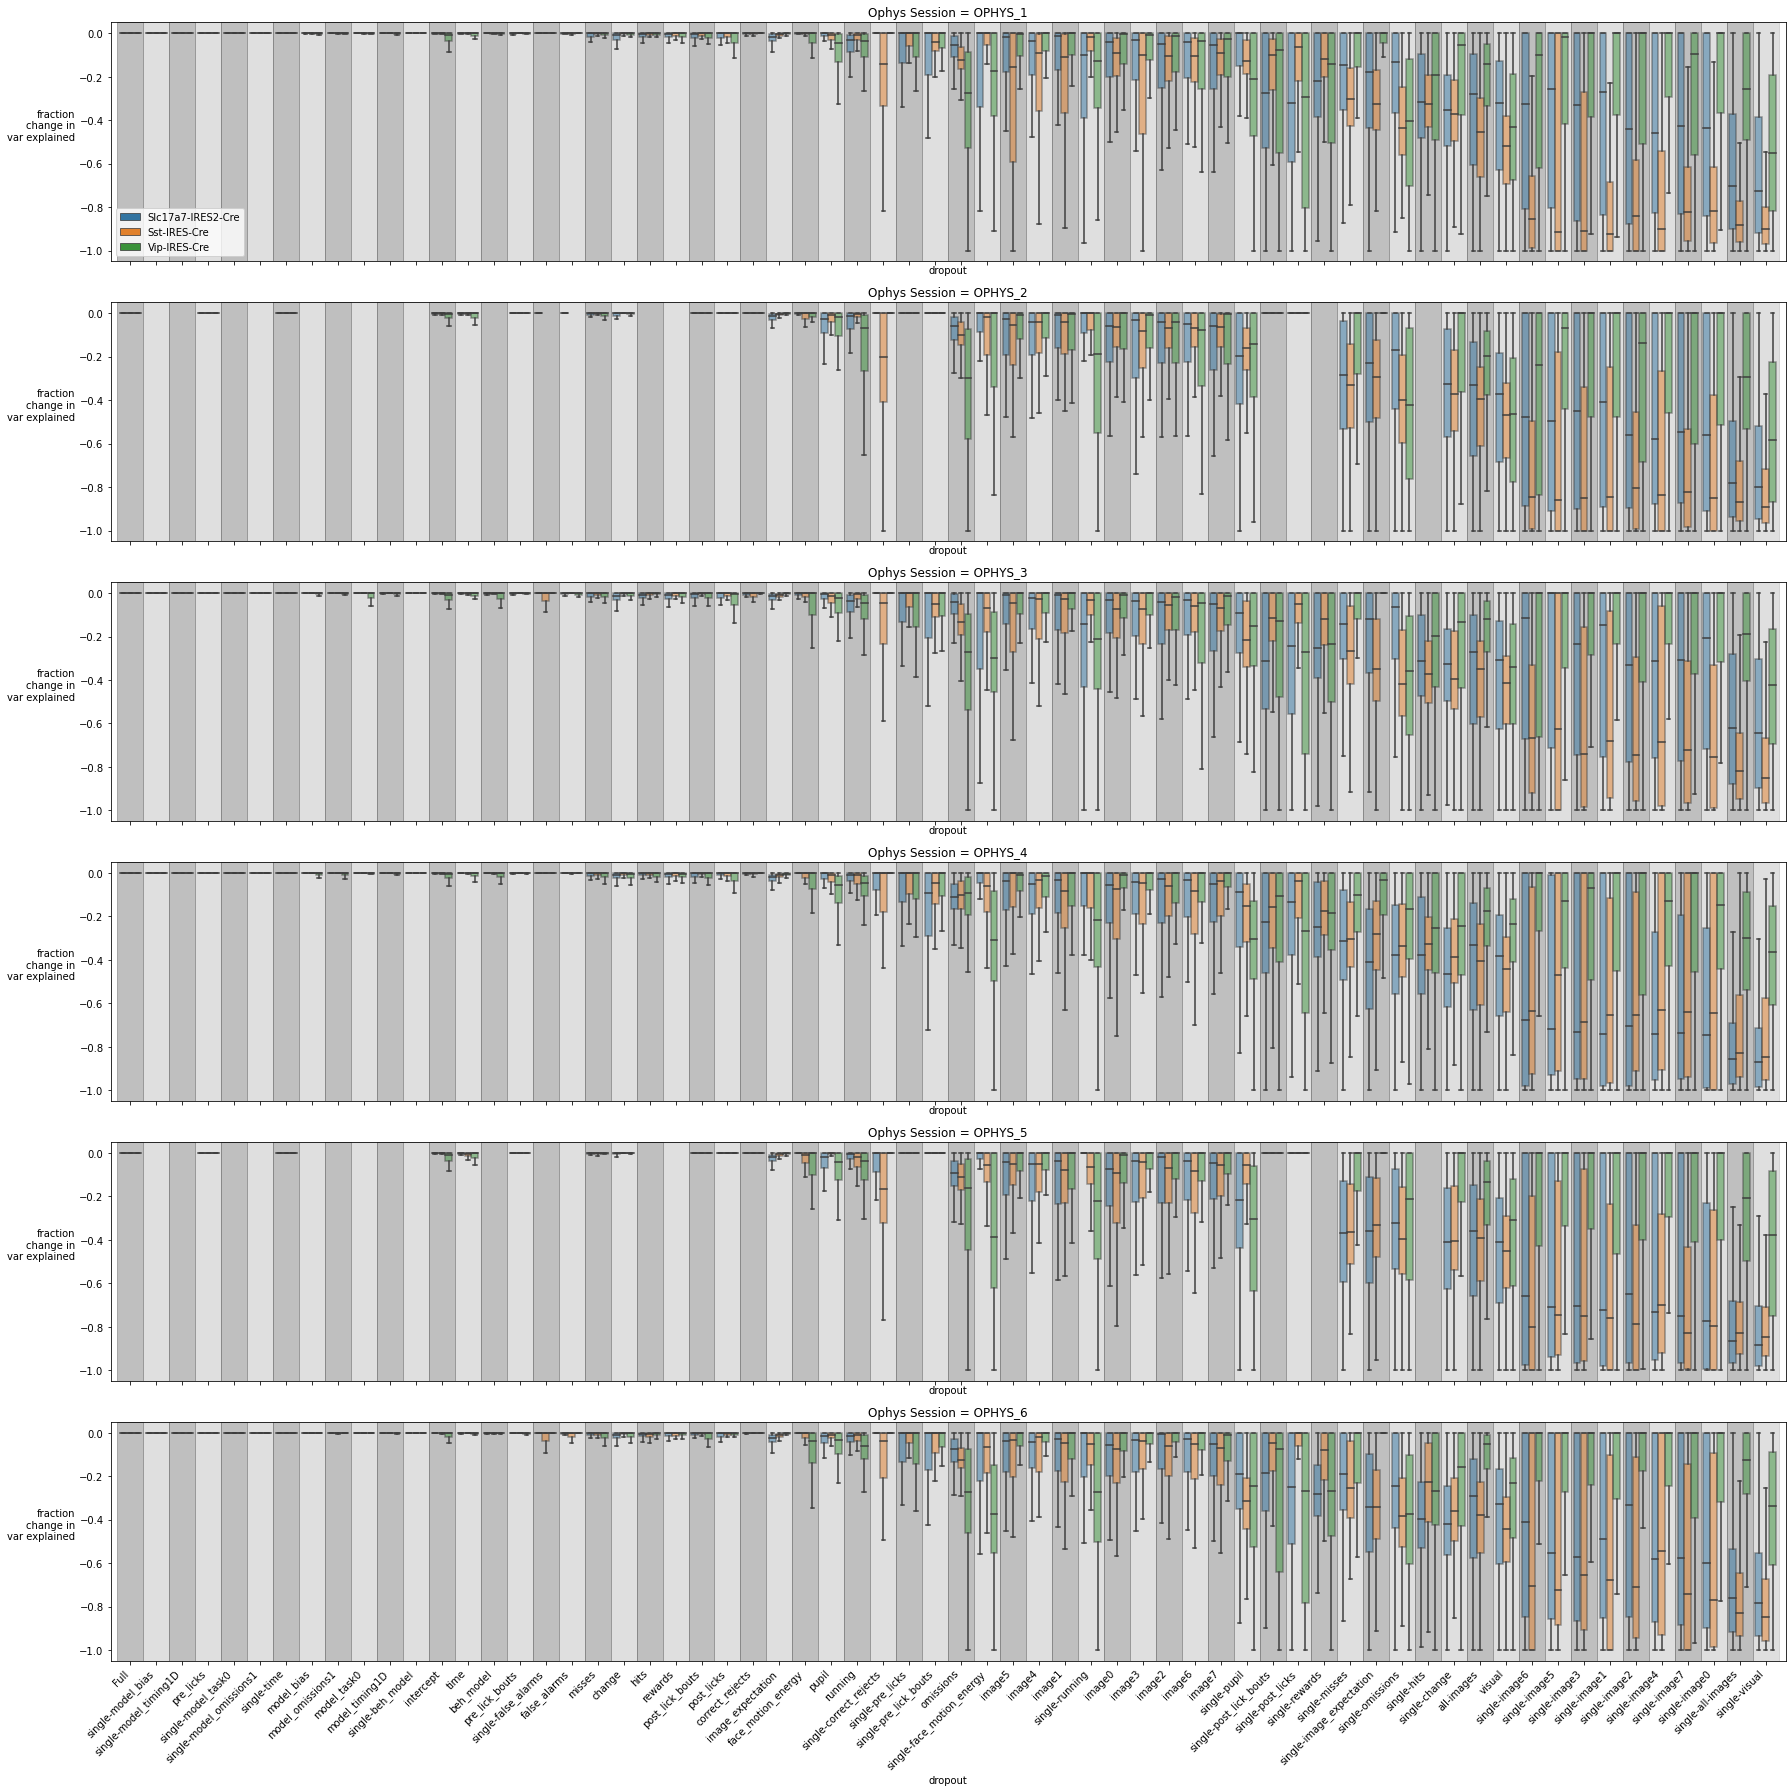

In [48]:
fig,ax=plt.subplots(6,1,figsize=(25,25),sharex=True)
show_dots = False
colors = ['black','gray']
row = 0
for _,session_prefix in enumerate(np.sort(results_summary['session_prefix'].unique())):
    data_to_plot = results_summary.query('session_prefix == @session_prefix and dropout not in @kernels_to_exclude and above_CV_threshold')
    bp = sns.boxplot(
        data = data_to_plot,
        x = 'dropout',
        y = 'adj_fraction_change_from_full',
        order=fraction_change_order,
        hue='cre_line',
        hue_order=genotype_order,
        ax=ax[row],
        fliersize=0,
        boxprops=dict(alpha=.5)
    )

    if show_dots:
        sp = sns.stripplot(
            data = data_to_plot.sample(1000),
            x = 'dropout',
            y = 'adj_fraction_change_from_full',
            order=fraction_change_order,
            hue='cre_line',
            hue_order=genotype_order,
            ax=ax[row],
            dodge=True,
            alpha=0.2
        )
#         sp.legend(loc='lower left')
    bp.set_xticklabels(labels=fraction_change_order, rotation=45,ha='right')
    ax[row].set_title('Ophys Session = {}'.format(session_prefix))
    ax[row].set_ylabel('fraction\nchange in\nvar explained',rotation=0,ha='right')

    if row != 0:
        bp.legend_.remove()
    else:
        bp.legend(loc='lower left')
        
    for i in range(len(fraction_change_order)):
        ax[row].axvspan(i-0.5,i+0.5,color=colors[i%2],alpha=0.25, zorder=-np.inf)
    row += 1
    


fig.tight_layout()